## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
def build_mlp_after_input_layer(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    請嘗試將 BN 放在 Activation 之前，並比較訓練結果
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)  
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
def build_mlp_before_activ(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    請於 BN 放在 Input Layer 後，並比較結果
    """
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)  
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95

In [9]:
# 1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
results_batchsize = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batchsize in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Batch Size  = %d" % (batchsize))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batchsize, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-batch_size-%s" % str(batchsize )
    results_batchsize[exp_name_tag] = {'train-loss': train_loss,
                                       'valid-loss': valid_loss,
                                       'train-acc': train_acc,
                                       'valid-acc': valid_acc}





Experiment with Batch Size  = 2


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 

50000/50000 [==============================] - 160s 3ms/step - loss: 2.2533 - acc: 0.1610 - val_loss: 2.7135 - val_acc: 0.1883
Epoch 28/50
50000/50000 [==============================] - 160s 3ms/step - loss: 2.2659 - acc: 0.1517 - val_loss: 3.0647 - val_acc: 0.1882
Epoch 29/50
50000/50000 [==============================] - 172s 3ms/step - loss: 2.2681 - acc: 0.1473 - val_loss: 2.6089 - val_acc: 0.1898
Epoch 30/50
50000/50000 [==============================] - 161s 3ms/step - loss: 2.2601 - acc: 0.1543 - val_loss: 2.5901 - val_acc: 0.2042
Epoch 31/50
50000/50000 [==============================] - 161s 3ms/step - loss: 2.2557 - acc: 0.1569 - val_loss: 2.8124 - val_acc: 0.1803
Epoch 32/50
50000/50000 [==============================] - 160s 3ms/step - loss: 2.2539 - acc: 0.1549 - val_loss: 2.6290 - val_acc: 0.2023
Epoch 33/50
50000/50000 [==============================] - 159s 3ms/step - loss: 2.2522 - acc: 0.1558 - val_loss: 2.7805 - val_acc: 0.1807
Epoch 34/50
50000/50000 [==============

50000/50000 [==============================] - 22s 431us/step - loss: 1.2388 - acc: 0.5620 - val_loss: 1.4251 - val_acc: 0.4961
Epoch 26/50
50000/50000 [==============================] - 22s 436us/step - loss: 1.2283 - acc: 0.5638 - val_loss: 1.3772 - val_acc: 0.5143
Epoch 27/50
50000/50000 [==============================] - 22s 431us/step - loss: 1.2233 - acc: 0.5656 - val_loss: 1.3912 - val_acc: 0.5079
Epoch 28/50
50000/50000 [==============================] - 22s 434us/step - loss: 1.2260 - acc: 0.5650 - val_loss: 1.3535 - val_acc: 0.5263
Epoch 29/50
50000/50000 [==============================] - 22s 433us/step - loss: 1.2147 - acc: 0.5667 - val_loss: 1.3888 - val_acc: 0.5047
Epoch 30/50
50000/50000 [==============================] - 22s 432us/step - loss: 1.2105 - acc: 0.5716 - val_loss: 1.3632 - val_acc: 0.5211
Epoch 31/50
50000/50000 [==============================] - 22s 436us/step - loss: 1.2038 - acc: 0.5736 - val_loss: 1.3608 - val_acc: 0.5238
Epoch 32/50
50000/50000 [=======

Epoch 23/50
50000/50000 [==============================] - 11s 225us/step - loss: 1.0662 - acc: 0.6183 - val_loss: 1.4292 - val_acc: 0.5011
Epoch 24/50
50000/50000 [==============================] - 11s 225us/step - loss: 1.0601 - acc: 0.6230 - val_loss: 1.5305 - val_acc: 0.4788
Epoch 25/50
50000/50000 [==============================] - 11s 226us/step - loss: 1.0431 - acc: 0.6277 - val_loss: 1.4093 - val_acc: 0.5152
Epoch 26/50
50000/50000 [==============================] - 11s 225us/step - loss: 1.0205 - acc: 0.6367 - val_loss: 1.4323 - val_acc: 0.5130
Epoch 27/50
50000/50000 [==============================] - 11s 230us/step - loss: 1.0147 - acc: 0.6376 - val_loss: 1.5164 - val_acc: 0.4970
Epoch 28/50
50000/50000 [==============================] - 11s 229us/step - loss: 1.0033 - acc: 0.6437 - val_loss: 1.5587 - val_acc: 0.4706
Epoch 29/50
50000/50000 [==============================] - 11s 225us/step - loss: 0.9855 - acc: 0.6512 - val_loss: 1.5167 - val_acc: 0.4927
Epoch 30/50
50000/50

50000/50000 [==============================] - 4s 82us/step - loss: 0.7180 - acc: 0.7487 - val_loss: 1.6586 - val_acc: 0.4764
Epoch 22/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.6930 - acc: 0.7573 - val_loss: 1.8742 - val_acc: 0.4621
Epoch 23/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.6745 - acc: 0.7653 - val_loss: 1.8446 - val_acc: 0.4559
Epoch 24/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.6372 - acc: 0.7797 - val_loss: 1.8379 - val_acc: 0.4525
Epoch 25/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.6187 - acc: 0.7823 - val_loss: 1.7870 - val_acc: 0.4734
Epoch 26/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.5869 - acc: 0.7957 - val_loss: 1.8982 - val_acc: 0.4663
Epoch 27/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.5753 - acc: 0.8002 - val_loss: 1.9481 - val_acc: 0.4516
Epoch 28/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 57us/step - loss: 0.7870 - acc: 0.7307 - val_loss: 1.5645 - val_acc: 0.4916
Epoch 20/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.7567 - acc: 0.7436 - val_loss: 1.6120 - val_acc: 0.4785
Epoch 21/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.7315 - acc: 0.7512 - val_loss: 1.6763 - val_acc: 0.4816
Epoch 22/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.6999 - acc: 0.7632 - val_loss: 1.7438 - val_acc: 0.4683
Epoch 23/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.6738 - acc: 0.7731 - val_loss: 1.6678 - val_acc: 0.4757
Epoch 24/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.6451 - acc: 0.7832 - val_loss: 1.7348 - val_acc: 0.4709
Epoch 25/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.6157 - acc: 0.7947 - val_loss: 1.7069 - val_acc: 0.4789
Epoch 26/50
50000/50000 [=====================

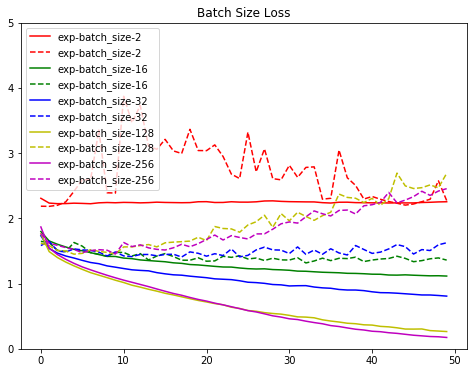

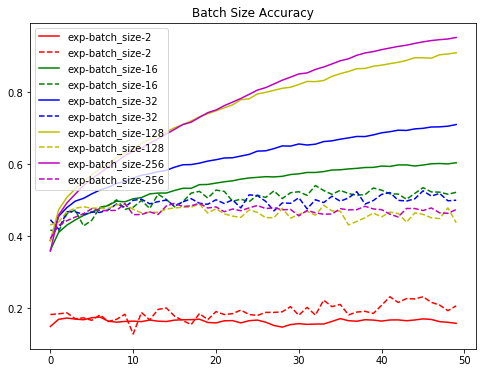

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]
"""Code Here
將結果繪出
"""
plt.figure(figsize=(8,6))
for i, cond in enumerate(results_batchsize.keys()):
    plt.plot(range(len(results_batchsize[cond]['train-loss'])),results_batchsize[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_batchsize[cond]['valid-loss'])),results_batchsize[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Batch Size Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_batchsize.keys()):
    plt.plot(range(len(results_batchsize[cond]['train-acc'])),results_batchsize[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_batchsize[cond]['valid-acc'])),results_batchsize[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Batch Size Accuracy")
plt.legend()
plt.show()

In [18]:
# 2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
keras.backend.clear_session() # 把舊的 Graph 清掉
print("BN before Activation Experiment")
model = build_mlp_after_input_layer(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=256, 
          validation_data=(x_test, y_test), 
          shuffle=True)
    
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]
    

BN before Activation Experiment
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
batch_normalization_4 (Batc

50000/50000 [==============================] - 3s 66us/step - loss: 0.0442 - acc: 0.9925 - val_loss: 2.5983 - val_acc: 0.5006
Epoch 48/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.0340 - acc: 0.9956 - val_loss: 2.6035 - val_acc: 0.5023
Epoch 49/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.0287 - acc: 0.9967 - val_loss: 2.6385 - val_acc: 0.5062
Epoch 50/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.0278 - acc: 0.9969 - val_loss: 2.6548 - val_acc: 0.4980


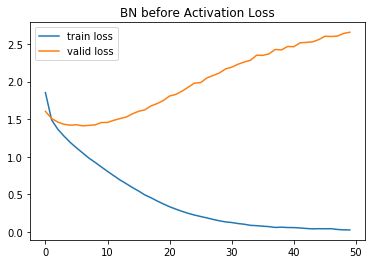

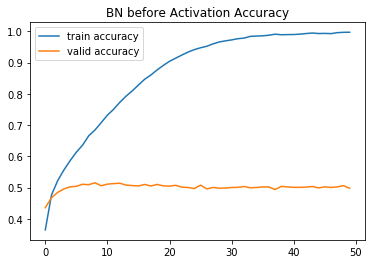

In [19]:
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("BN before Activation Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("BN before Activation Accuracy")
plt.show()

In [20]:
# 3.請於 BN 放在 Input Layer 後，並比較結果
keras.backend.clear_session() # 把舊的 Graph 清掉
print("BN after Input Layer Experiment")
model = build_mlp_before_activ(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=256, 
          validation_data=(x_test, y_test), 
          shuffle=True)
    
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

BN after Input Layer Experiment
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)             

50000/50000 [==============================] - 3s 54us/step - loss: 0.2177 - acc: 0.9402 - val_loss: 2.2275 - val_acc: 0.4855


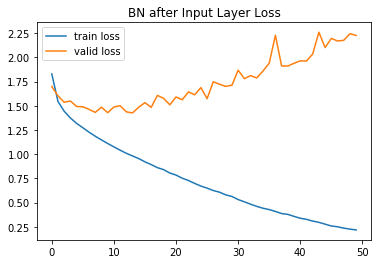

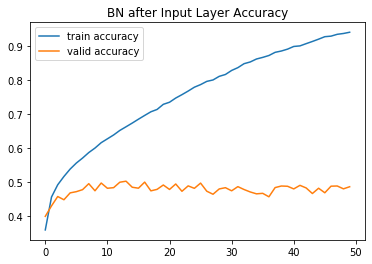

In [21]:
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("BN after Input Layer Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("BN after Input Layer Accuracy")
plt.show()

In [ ]:
""" 
結論:
1. Batch size 設 32 最後得到的 accuracy 較高
2. BN 放在 Activation 之前 的結果, accuracy 有比範例高一點
3. BN 放在 Input Layer 後 accuracy 也比範例高一點



"""
